In [4]:
# Data Processing
import numpy as np
import pandas as pd

# Basic Visualization tools
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_palette('husl')


# Bokeh (interactive visualization)
from bokeh.io import show, output_notebook
from bokeh.palettes import Spectral9
from bokeh.plotting import figure
output_notebook() # You can use output_file()

# Special Visualization
from wordcloud import WordCloud # wordcloud
import missingno as msno # check missing value

# Check file list
import os
print(os.listdir('../17k-apple-app-store-strategy-games'))

Loading BokehJS ...

['.ipynb_checkpoints', 'appstore_games.csv', 'EDA_with_common_libs.ipynb', 'Untitled.ipynb']


In [6]:
data = pd.read_csv('appstore_games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
URL                             17007 non-null object
ID                              17007 non-null int64
Name                            17007 non-null object
Subtitle                        5261 non-null object
Icon URL                        17007 non-null object
Average User Rating             7561 non-null float64
User Rating Count               7561 non-null float64
Price                           16983 non-null float64
In-app Purchases                7683 non-null object
Description                     17007 non-null object
Developer                       17007 non-null object
Age Rating                      17007 non-null object
Languages                       16947 non-null object
Size                            17006 non-null float64
Primary Genre                   17007 non-null object
Genres                          17007 non-null object
Original Release Date       

## Checking Missing Data (missingno)

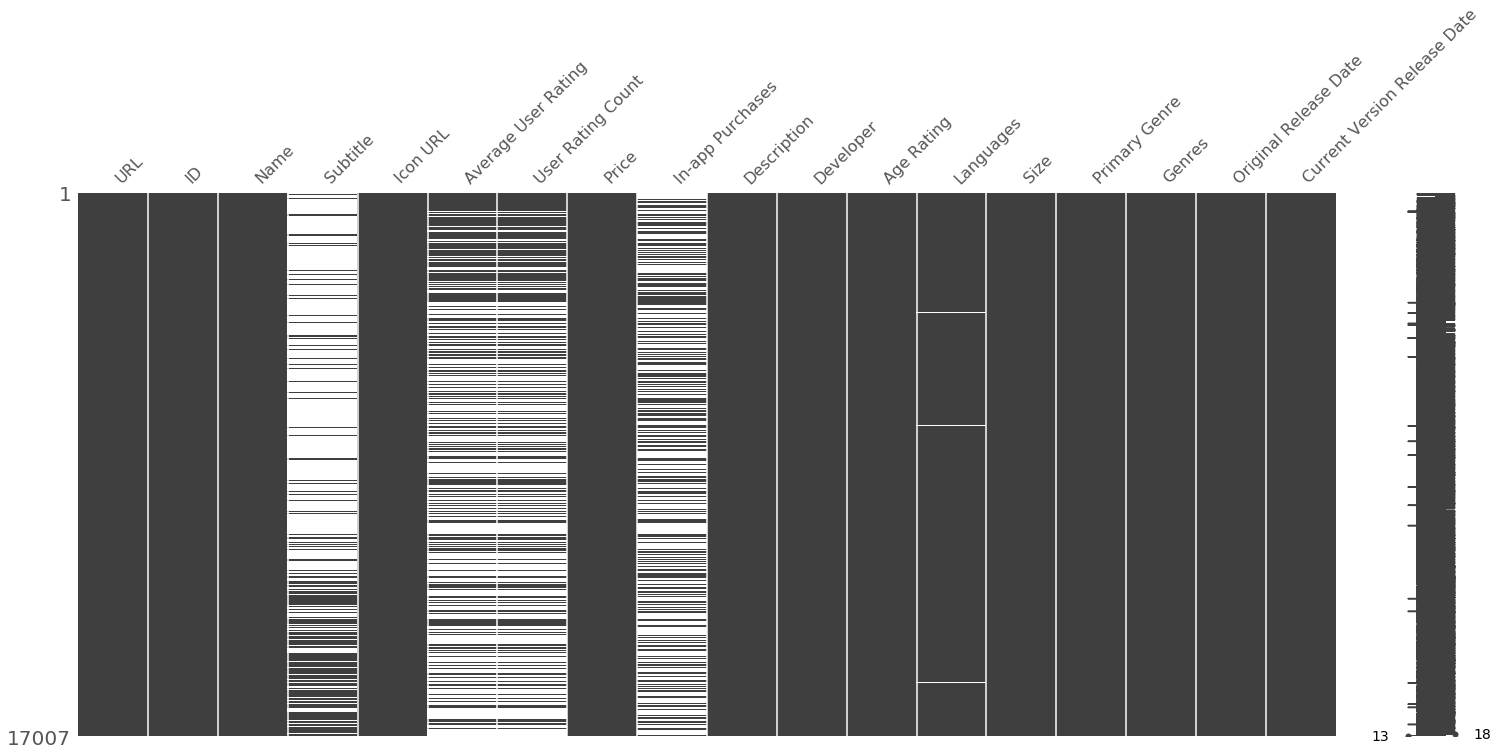

In [7]:
msno.matrix(data)

Subtitle, Average User Rating, User rating count and in-app Purchases are missing a lot of data

## Name and Subtitle (Word Cloud)

word cloud is a novel visual representation of text data, typically used to depict keyword metadata on websites, or to visualize free form text. Using WordCloud package, we can easily make wordcloud image.

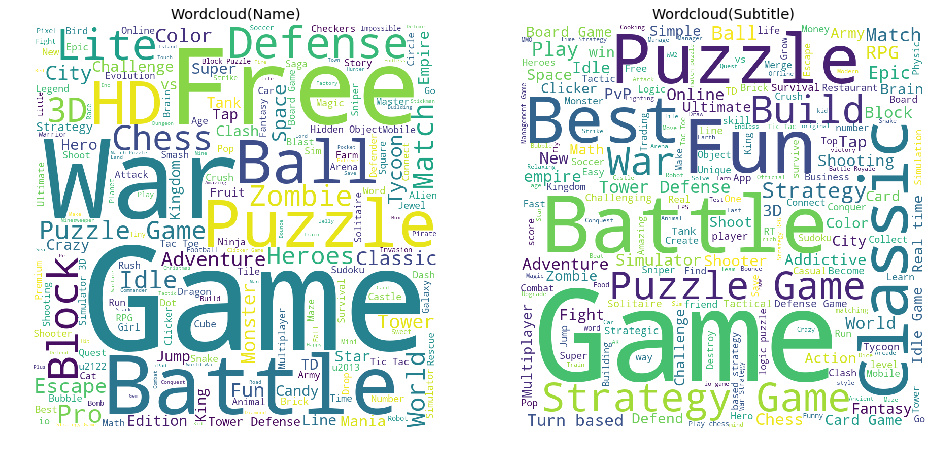

Wall time: 4.33 s


In [8]:
%%time
fig, ax = plt.subplots(1, 2, figsize=(16,32))
wordcloud = WordCloud(background_color='white',width=800, height=800).generate(' '.join(data['Name']))
wordcloud_sub = WordCloud(background_color='white',width=800, height=800).generate(' '.join(data['Subtitle'].dropna().astype(str)) )
ax[0].imshow(wordcloud)
ax[0].axis('off')
ax[0].set_title('Wordcloud(Name)')
ax[1].imshow(wordcloud_sub)
ax[1].axis('off')
ax[1].set_title('Wordcloud(Subtitle)')
plt.show()

- Name: Game, Free, War, Battle, Puzzle...
- Subtitle: Game, Battle, Fun, Best, Classic...

## Icon URL (request & Crawling)

- single url crawling takes ~0.5s
- just testing sample code (100 images)

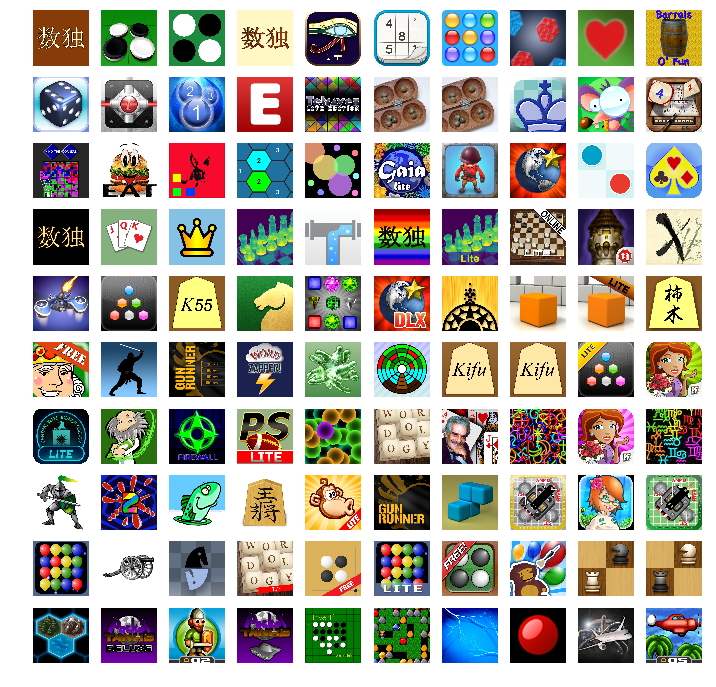

Wall time: 19.2 s


In [9]:
%%time
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

fig, ax = plt.subplots(10,10, figsize=(12,12))

for i in range(100):
    r = requests.get(data['Icon URL'][i])
    im = Image.open(BytesIO(r.content))
    ax[i//10][i%10].imshow(im)
    ax[i//10][i%10].axis('off')
plt.show()

## Average User Rating (Bokeh: countplot compare)

In [10]:
aur = data['Average User Rating'].value_counts().sort_index()
p = figure(x_range=list(map(str, aur.index.values)), 
           plot_height=250, title="Average User Rating", 
           toolbar_location=None, 
           tools="")

p.vbar(x=list(map(str, aur.index.values)), 
       top=aur.values, 
       width=0.9, 
       color=Spectral9)

p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

### Seaborn and matplotlib version

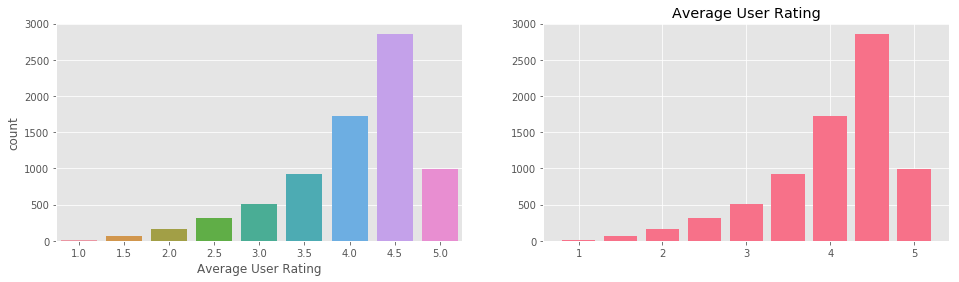

In [11]:
fig, ax = plt.subplots(1,2,figsize=(16, 4))
sns.countplot(data['Average User Rating'],ax=ax[0]) # seaborn
ax[1].bar(aur.index, aur, width=0.4) # matplotlib
ax[1].set_title('Average User Rating')
plt.show()

## Price and Rating (seaborn: regplot, lmplot)

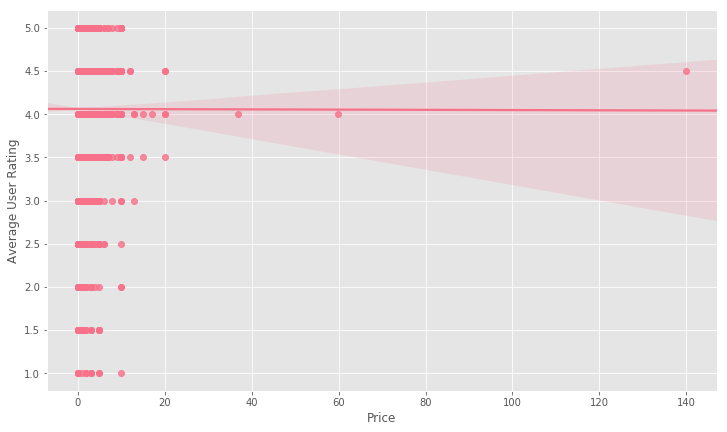

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12, 7), dpi=72)
sns.regplot(data=data, x='Price', y='Average User Rating', ax=ax)
plt.show()

There seems to be little correlation between price and rating

## Primary Genre & Genres (Heatmap + networkx, Network Graph)

In [13]:
genre = data['Primary Genre'].value_counts()
p = figure(x_range=list(map(str, genre.index.values)), 
           plot_height=250, plot_width=1500, title="Primary Genre", 
           toolbar_location=None, 
           tools="")

p.vbar(x=list(map(str, genre.index.values)), 
       top=genre.values, 
       width=0.9, 
       color=Spectral9)

p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

In [14]:
data['GenreList'] = data['Genres'].apply(lambda s : s.replace('Games','').replace('&',' ').replace(',', ' ').split()) 
gameTypes = []
for i in data['GenreList']: gameTypes += i
gameTypes = set(gameTypes)
print("There are {} types in the Game Dataset".format(len(set(gameTypes))))

There are 56 types in the Game Dataset


### Heatmap

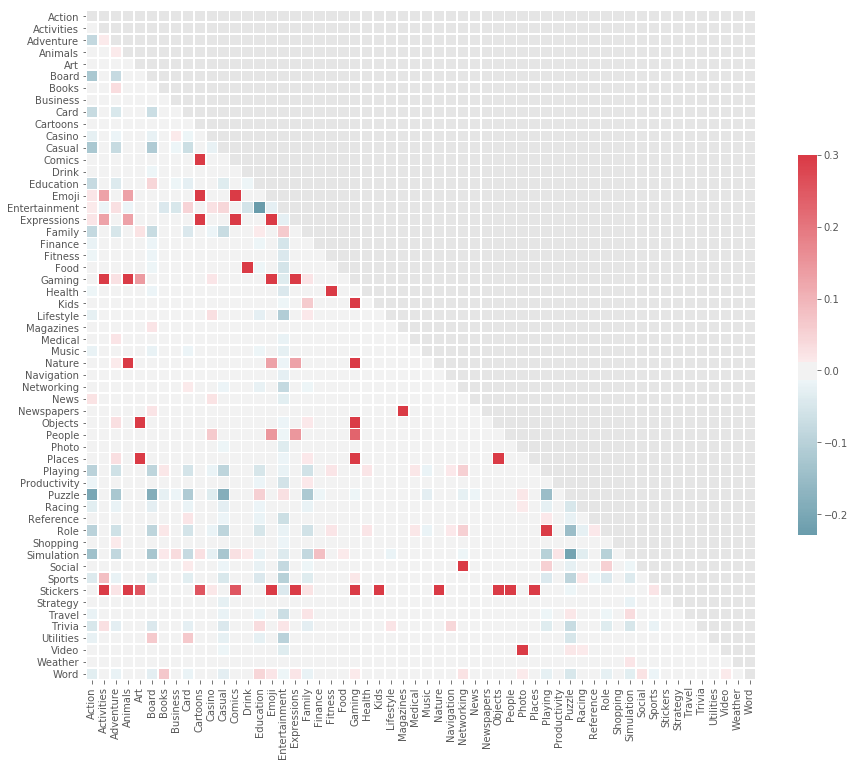

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer # Similar to One-Hot Encoding

test = data['GenreList']
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)

corr = res.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Network Graph

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

C:\Users\Matt\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


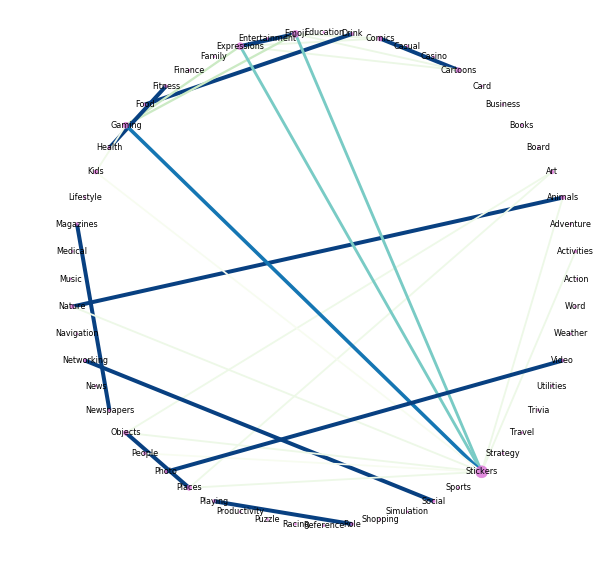

C:\Users\Matt\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


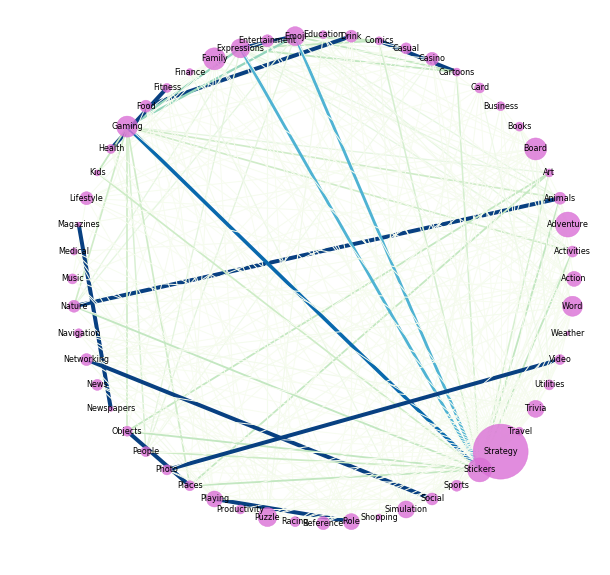

In [16]:
import networkx as nx

stocks = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: stocks[x])
G.edges(data=True)

def create_corr_network(G, corr_direction, min_correlation):
    H = G.copy()
    for stock1, stock2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)

    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive": edge_colour = plt.cm.GnBu 
    else: edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, edge_list=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 
    
create_corr_network(G, 'positive', 0.3)
create_corr_network(G, 'positive', -0.3)

## Original Release Date & Size (time series)

In [17]:
data['Original Release Date'] = pd.to_datetime(data['Original Release Date'], format = '%d/%m/%Y')
date_size = pd.DataFrame({'size':data['Size']})
date_size = date_size.set_index(data['Original Release Date'])
date_size = date_size.sort_values(by=['Original Release Date'])
date_size.head()

,size
Original Release Date,
2008-07-11,15853568.0
2008-07-11,12328960.0
2008-07-11,674816.0
2008-07-18,34689024.0
2008-07-23,21552128.0


In [18]:
date_size['size'] = date_size['size'].apply(lambda b : b//(2**10)) # B to KB

### Simple plotting version

In [19]:
fig = figure(x_axis_type='datetime',           
             plot_height=250, plot_width=750,
             title='Date vs App Size')
fig.line(y='size', x='Original Release Date', source=date_size)
show(fig)

### Just a bit more elegant version

In [20]:
#Let's look at the month for trends.
#We can use resample method.
#The criteria for grouping depend on the parameters.
#'M' means 'end of month', 'Y' means 'Year'.
monthly_size = date_size.resample('M').mean()
tmp = date_size.resample('M')
monthly_size['min'] = tmp.min()
monthly_size['max'] = tmp.max()
monthly_size.head()

,size,min,max
Original Release Date,,,
2008-07-31,19545.142857,659.0,47532.0
2008-08-31,32178.300000,714.0,119948.0
2008-09-30,11157.166667,433.0,51012.0
2008-10-31,24377.285714,1268.0,73283.0
2008-11-30,12429.666667,1710.0,43291.0


In [21]:
fig = figure(x_axis_type='datetime',           
             plot_height=250, plot_width=750,
             title='Date vs App Size (Monthly)')
fig.line(y='size', x='Original Release Date', source=monthly_size, line_width=2, line_color='Green')
show(fig)

In [22]:
yearly_size = date_size.resample('Y').mean()
monthly_size.head()
fig = figure(x_axis_type='datetime',           
             plot_height=250, plot_width=750,
             title='Date vs App Size (Monthly & Yearly)')
fig.line(y='size', x='Original Release Date', source=monthly_size, line_width=2, line_color='Green', alpha=0.5)
fig.line(y='size', x='Original Release Date', source=yearly_size, line_width=2, line_color='Orange', alpha=0.5)
show(fig)